In [274]:
IS_COLAB = False
DEV = False
EXP_DIR = "exp006"
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -q pandas==2.0.3 recbole colorama ray kmeans_pytorch polars==0.15.16
    %cd /content/drive/MyDrive/signate/SMBC_tree/exp
    DATA_PATH = "/content/drive/MyDrive/signate/finance_2/input_data"
    OUTPUT_PATH = f"/content/drive/MyDrive/signate/finance_2/exp/{EXP_DIR}"
else:
    %cd /Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/SMBC_tree/exp
    DATA_PATH = "/Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/finance_2/input_data"
    OUTPUT_PATH = f"/Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/finance_2/exp/{EXP_DIR}"

/Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/SMBC_tree/exp


In [275]:
import os
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from sklearn.model_selection import StratifiedKFold

%matplotlib inline


# ref: Kaggleコード遺産 https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# 再現性確保!
seed_everything(510)

In [276]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold,KFold

class CFG:
    seed = 122
    fold_num = 5

In [277]:
train_df = pl.read_csv(f'{DATA_PATH}/train.csv')
test_df = pl.read_csv(f'{DATA_PATH}/test.csv')
latlon_df = pl.read_csv(f'{DATA_PATH}/unique_addresses.csv')
sample_submission_df = pl.read_csv(f'{DATA_PATH}/sample_submission.csv')

In [278]:
train_df = train_df.drop('')
test_df = test_df.drop('')

# fold分け

In [279]:
# Stratified K-Foldの初期化
skf = StratifiedKFold(n_splits=CFG.fold_num, shuffle=True, random_state=CFG.seed)
# フォールド割り当ての準備
fold_assignments = np.full(train_df.height, -1, dtype=int)
# ラベルに基づいてフォールドを割り当てる
for i, (_, valid_index) in enumerate(skf.split(train_df, train_df['MIS_Status'])):
    fold_assignments[valid_index] = i
# fold列をDataFrameに追加
train_df = train_df.with_columns(pl.Series("fold", fold_assignments))

# latlon_dfをjoin

In [280]:
# latlon_dfの結合
train_df = train_df.join(latlon_df, on='City', how='left')
test_df = test_df.join(latlon_df, on='City', how='left')

# DisbursementDateとApprovalDateを数値に変換

In [281]:
month_to_num_dic = [["Jan", 1], ["Feb", 2], ["Mar", 3], ["Apr", 4], ["May", 5], ["Jun", 6], ["Jul", 7], ["Aug", 8], ["Sep", 9], ["Oct", 10], ["Nov", 11], ["Dec", 12]]

for col_name in ["DisbursementDate", "ApprovalDate"]:
    # Monthを抽出
    train_df = train_df.with_columns(pl.col(col_name).str.extract(r'-(.+)-').alias(f"{col_name}Month"))
    test_df = test_df.with_columns(pl.col(col_name).str.extract(r'-(.+)-').alias(f"{col_name}Month"))
    # Yearを抽出
    train_df = train_df.with_columns(pl.col(col_name).str.extract("(\d+)$", 1).cast(pl.Int64).alias(f"{col_name}Year"))
    test_df = test_df.with_columns(pl.col(col_name).str.extract("(\d+)$", 1).cast(pl.Int64).alias(f"{col_name}Year"))
    # Dayを抽出
    train_df = train_df.with_columns(pl.col(col_name).str.extract("^(\d+)", 1).cast(pl.Int64).alias(f"{col_name}Day"))
    test_df = test_df.with_columns(pl.col(col_name).str.extract("^(\d+)", 1).cast(pl.Int64).alias(f"{col_name}Day"))

    # month_to_num_dicに従って数値に変換
    for month_to_num_dic_i in month_to_num_dic:
        train_df = train_df.with_columns(pl.col(f"{col_name}Month").str.replace(month_to_num_dic_i[0], str(month_to_num_dic_i[1])))
        test_df = test_df.with_columns(pl.col(f"{col_name}Month").str.replace(month_to_num_dic_i[0], str(month_to_num_dic_i[1])))
    # 数値に変換
    train_df = train_df.with_columns(pl.col(f"{col_name}Month").cast(pl.Int64))
    test_df = test_df.with_columns(pl.col(f"{col_name}Month").cast(pl.Int64))

    # DisbursementDateを削除
    train_df = train_df.drop(col_name)
    test_df = test_df.drop(col_name)

# 金額系のカラムを数値化

In [282]:
for col_name in ["DisbursementGross", "GrAppv", "SBA_Appv"]:
    # 1文字目が"$"なので削除し、数値に変換
    train_df = train_df.with_column(pl.col(col_name).str.replace_all(",","").str.strip().str.slice(1,).str.extract("^(.+)\.").cast(pl.Int64))
    test_df = test_df.with_column(pl.col(col_name).str.replace_all(",","").str.strip().str.slice(1,).str.extract("^(.+)\.").cast(pl.Int64))

# テストデータセットのBankStateのPRをNoneに変更

In [283]:
# テストデータセットのBankStateのPRをNoneに変更
test_df = test_df.with_column(pl.col("BankState").str.replace("PR", "CA"))

In [284]:
train_df = train_df.drop("City")
test_df = test_df.drop("City")

# Sectorを業種別にする

In [285]:
train_df = train_df.with_column(pl.when(pl.col('Sector')==32).then(31)
                                .when(pl.col('Sector')==33).then(31)
                                .when(pl.col('Sector')==45).then(44)
                                .when(pl.col('Sector')==49).then(48)
                                .otherwise(pl.col('Sector')).alias('Sector'))
test_df = test_df.with_column(pl.when(pl.col('Sector')==32).then(31)
                                .when(pl.col('Sector')==33).then(31)
                                .when(pl.col('Sector')==45).then(44)
                                .when(pl.col('Sector')==49).then(48)
                                .otherwise(pl.col('Sector')).alias('Sector'))

# カラム同士の四則演算

- 銀行によって支払われた金額（DisbursementGross）- 銀行によって承認されたローンの総額（GrAppv）
- 銀行によって支払われた金額（DisbursementGross）- SBAが保証する承認されたローンの金額（SBA_Appv）
- 銀行によって承認されたローンの総額（GrAppv）- SBAが保証する承認されたローンの金額（SBA_Appv）

In [286]:
diff_list = [
    ["DisbursementGross", "GrAppv"], 
    ["DisbursementGross", "SBA_Appv"], 
    ["GrAppv", "SBA_Appv"]
    ]

for diff_combo in diff_list:
    train_df = train_df.with_columns((pl.col(diff_combo[0]) - pl.col(diff_combo[1])).alias(f'{diff_combo[0]}_{diff_combo[1]}_diff'))
    test_df = test_df.with_columns((pl.col(diff_combo[0]) - pl.col(diff_combo[1])).alias(f'{diff_combo[0]}_{diff_combo[1]}_diff'))

- 銀行によって支払われた金額（DisbursementGross）/ 融資の期間（Term）
- 銀行によって承認されたローンの総額（GrAppv）/ 融資の期間（Term）
- SBAが保証する承認されたローンの金額（SBA_Appv）/ 融資の期間（Term）

In [287]:
div_list = [
    # ["DisbursementGross", "Term"], 
    ["GrAppv", "Term"], 
    ["SBA_Appv", "Term"], 
    ["NoEmp", "Term"], 
    # ["DisbursementGross", "NoEmp"], 
    # ["GrAppv", "NoEmp"], 
    # ["SBA_Appv", "NoEmp"], 
    ["DisbursementGross_GrAppv_diff", "Term"], 
    ["DisbursementGross_SBA_Appv_diff", "Term"], 
    ["GrAppv_SBA_Appv_diff", "Term"], 
    # ["DisbursementGross_GrAppv_diff", "NoEmp"], 
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"], 
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
    ]

for div_combo in div_list:
    train_df = train_df.with_columns((pl.col(div_combo[0]) / pl.col(div_combo[1])).alias(f'{div_combo[0]}_{div_combo[1]}_div'))
    test_df = test_df.with_columns((pl.col(div_combo[0]) / pl.col(div_combo[1])).alias(f'{div_combo[0]}_{div_combo[1]}_div'))

# ターゲットエンコーディング

In [288]:
# ターゲットエンコーディング
def target_encoding(train_df, test_df, column_name):
    target_col = "MIS_Status"
    te_df = train_df.select(pl.col([column_name, 'fold', target_col]))
    train_target_encoding_df = pl.DataFrame()
    for fold in range(CFG.fold_num):
        te_df_fold = te_df.filter(pl.col('fold')!=fold)
        te_df_fold = te_df_fold.groupby(column_name).agg(
            pl.col(target_col).mean().alias(f'{column_name}_{target_col}_mean')
        )
        te_df_fold = te_df_fold.with_columns(pl.lit(fold).alias('fold').cast(pl.Int64))
        train_target_encoding_df = pl.concat([train_target_encoding_df, te_df_fold])
    test_target_encoding_df = te_df.groupby(column_name).agg(
        pl.col(target_col).mean().alias(f'{column_name}_{target_col}_mean'),
    )

    train_df = train_df.join(train_target_encoding_df, on=[column_name, 'fold'], how='left')
    test_df = test_df.join(test_target_encoding_df, on=column_name, how='left')

    return train_df, test_df

In [289]:
target_enc_columns = [
    "UrbanRural", 
    "RevLineCr", 
    "LowDoc", 
    "ApprovalFY", 
    "FranchiseCode"
    ]
for column_name in target_enc_columns:
    train_df, test_df = target_encoding(train_df, test_df, column_name)

# ラベルエンコーディング

In [290]:
# LabelEncoding は scikit-learn に変換ロジックが用意されていますのでそれを利用するのが便利です。
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

# train_dfのdtypeがstrの列を取得
df_schema = train_df.schema
str_col_list = []
for col in train_df.columns:
    # Utf8かどうかを判定
    if df_schema[col] == pl.datatypes.Utf8:
        str_col_list.append(col)

for col in str_col_list:
    print(col)
    le = LabelEncoder()
    train_target_col = train_df.select(pl.col(col)).to_numpy()
    train_target_col = column_or_1d(train_target_col, warn=True)
    train_label_col = le.fit_transform(train_target_col)
    train_df = train_df.with_columns([pl.Series(train_label_col).alias(col)])
    test_target_col = test_df.select(pl.col(col)).to_numpy()
    test_target_col = column_or_1d(test_target_col, warn=True)
    test_label_col = le.transform(test_target_col)
    test_df = test_df.with_columns([pl.Series(test_label_col).alias(col)])

RevLineCr
LowDoc
State
BankState


/var/folders/b1/j2lv6xcn5zb1__9182lck3vh0000gn/T/ipykernel_96971/648166288.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  train_target_col = column_or_1d(train_target_col, warn=True)
/var/folders/b1/j2lv6xcn5zb1__9182lck3vh0000gn/T/ipykernel_96971/648166288.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  test_target_col = column_or_1d(test_target_col, warn=True)
/var/folders/b1/j2lv6xcn5zb1__9182lck3vh0000gn/T/ipykernel_96971/648166288.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  train_target_col = column_or_1d(train_target_col, warn=True)
/var/folders/b1/j2lv6xcn5zb1__9182lck3vh0000gn/T/ipykernel_96971/648166288.py:21: DataConversionWar

# 学習

In [291]:
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def lgb_macro_f1(y_true, y_pred, s):
    # LightGBMは予測値を確率で返すので、閾値（0.5など）を設定して二値に変換する
    y_pred = np.round(y_pred)
    ratio_list = [[0.99, 0.01], [0.95, 0.05], [0.8, 0.2], [0.55, 0.45], [0.5, 0.5]]
    f1 = np.mean(f1_score(y_true, y_pred, average=None)*np.array(ratio_list[s]))
    return 'macroF1', f1, True

# def lgb_macro_f1(y_true, y_pred):
#     # LightGBMは予測値を確率で返すので、閾値（0.5など）を設定して二値に変換する
#     y_pred = np.round(y_pred)
#     f1 = f1_score(y_true, y_pred, average="macro")
#     return 'macroF1', f1, True

def lgb_macro_recall(y_true, y_pred):
    # LightGBMは予測確率を渡すため、最大確率のクラスを予測ラベルとする
    y_pred_labels = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    ratio_list = [[0.2, 0.1, 0.7], [0.3, 0.1, 0.6], [0.4, 0.1, 0.5], [0.25, 0.15, 0.6], [1, 1, 1]]
    # Macro Recallの計算
    recall = sum(recall_score(y_true, y_pred_labels, average=None)*np.array(ratio_list[s]))
    # LightGBMのカスタムメトリックは(name, value, is_higher_better)のタプルを返す
    return 'macro_recall', recall, True

def lgb_macro_precision(y_true, y_pred):
    # LightGBMは予測確率を渡すため、最大確率のクラスを予測ラベルとする
    y_pred_labels = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    ratio_list = [[0.2, 0.1, 0.7], [0.3, 0.1, 0.6], [0.4, 0.1, 0.5], [0.25, 0.15, 0.6], [1, 1, 1]]
    # Macro Recallの計算
    precision = sum(precision_score(y_true, y_pred_labels, average=None, zero_division=0)*np.array(ratio_list[s]))
    # LightGBMのカスタムメトリックは(name, value, is_higher_better)のタプルを返す
    return 'macro_precision', precision, True

In [292]:
custom_metric_list = [
    # lgb_macro_recall, 
    lgb_macro_f1
    ]
sample_ratio_list = [
    # [1.5, 1.9], 
    2
    ]

In [296]:
model_list = []
oof_proba_list_metric = []
target_col = "MIS_Status"
for custom_metric, sample_ratio in zip(custom_metric_list, sample_ratio_list):
    model_list_ = []
    print(f'==================== {custom_metric} ====================')
    oof_proba_list = np.zeros((len(train_df), 2), dtype=np.float32)
    sample_n = 5
    for n in range(sample_n):
        print(f'==================== seed {n} ====================')
        train_df_ = train_df.to_pandas()

        cv = []
        for i in range(CFG.fold_num):
            cv.append((np.array(train_df_[train_df_['fold']!=i].index.to_list()), np.array(train_df_[train_df_['fold']==i].index.to_list()))) 

        oof_pred = np.zeros((len(train_df_), ), dtype=np.float32)

        for fold in range(CFG.fold_num):
            train_fold_df = train_df.filter(pl.col("fold") != fold)
            num_0 = len(train_fold_df.filter(pl.col(target_col) == 0))
            train_df_0 = train_fold_df.filter(pl.col(target_col) == 0)
            train_df_1 = train_fold_df.filter(pl.col(target_col) == 1).sample(round(num_0*sample_ratio), seed=n)
            # train_df_0とtrain_df_1とtrain_df_2を結合
            train_fold_df = pl.concat([train_df_0, train_df_1])
            train_fold_df = train_fold_df.to_pandas()
            valid_fold_df = train_df_[train_df_.fold == fold]
            train_fold_X = train_fold_df.drop([target_col,"fold"], axis=1)
            train_fold_y = train_fold_df[target_col]
            valid_fold_X = valid_fold_df.drop([target_col,"fold"], axis=1)
            valid_fold_y = valid_fold_df[target_col]
            params = {
                'objective': 'binary',
                'learning_rate': .01,
                'max_depth': 6,
                'n_estimators': 1000,
                'colsample_bytree': .7,
                'importance_type': 'gain',
                'metric': 'None',
                'verbose': -1,
                'seed': 127,
            }
            verbose_eval = 0 # この数字を1にすると学習時のスコア推移がコマンドライン表示される
            model = lgb.LGBMClassifier(**params)
            model.fit(train_fold_X, train_fold_y, 
                eval_set=[(valid_fold_X, valid_fold_y)],
                eval_metric=lambda y_true, y_pred: custom_metric(y_true, y_pred, n),
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=True),
                    lgb.log_evaluation(verbose_eval)
                ])

            # 予測
            oof_proba_list[cv[fold][1]] += model.predict_proba(valid_fold_X)
            model_list_.append(model)
    oof_proba_list /= sample_n
    oof_proba_list_metric.append(oof_proba_list)
    model_list.append(model_list_)

==================== <function lgb_macro_f1 at 0x28e95b5e0> ====================
==================== seed 0 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[233]	valid_0's macroF1: 0.221151
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[183]	valid_0's macroF1: 0.212417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[500]	valid_0's macroF1: 0.220569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid_0's macroF1: 0.203761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's macroF1: 0.213022
==================== seed 1 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's macroF1: 0.224519
Training until validation scores don't im

In [297]:
for oof, custom_metric in zip(oof_proba_list_metric, custom_metric_list):
    print(f'==================== {custom_metric} ====================')
    train_df_pred = train_df.with_columns(pl.Series(np.argmax(oof, axis=1)).alias("pred"))
    display(train_df_pred[target_col].value_counts().sort(target_col))
    display(train_df_pred['pred'].value_counts().sort("pred"))
    score = f1_score(train_df_pred[target_col], train_df_pred['pred'], average='macro')
    print(score)
    print(f1_score(train_df_pred[target_col], train_df_pred['pred'], average=None))

==================== <function lgb_macro_f1 at 0x28e95b5e0> ====================


MIS_Status,counts
i64,u32
0,4540
1,37767


pred,counts
i64,u32
0,3210
1,39097


0.6771379663452499
[0.41341935 0.94085658]


In [201]:
"""
==================== <function lgb_macro_f1 at 0x15a6b98b0> ====================
3887
38420
0.6794164687395048
[0.42268898 0.93614396]
"""

'\n==================== <function lgb_macro_f1 at 0x15a6b98b0> ====================\n3821\n38486\n0.6791562743074054\n[0.42171989 0.93659266]\n'

### 特徴量重要度

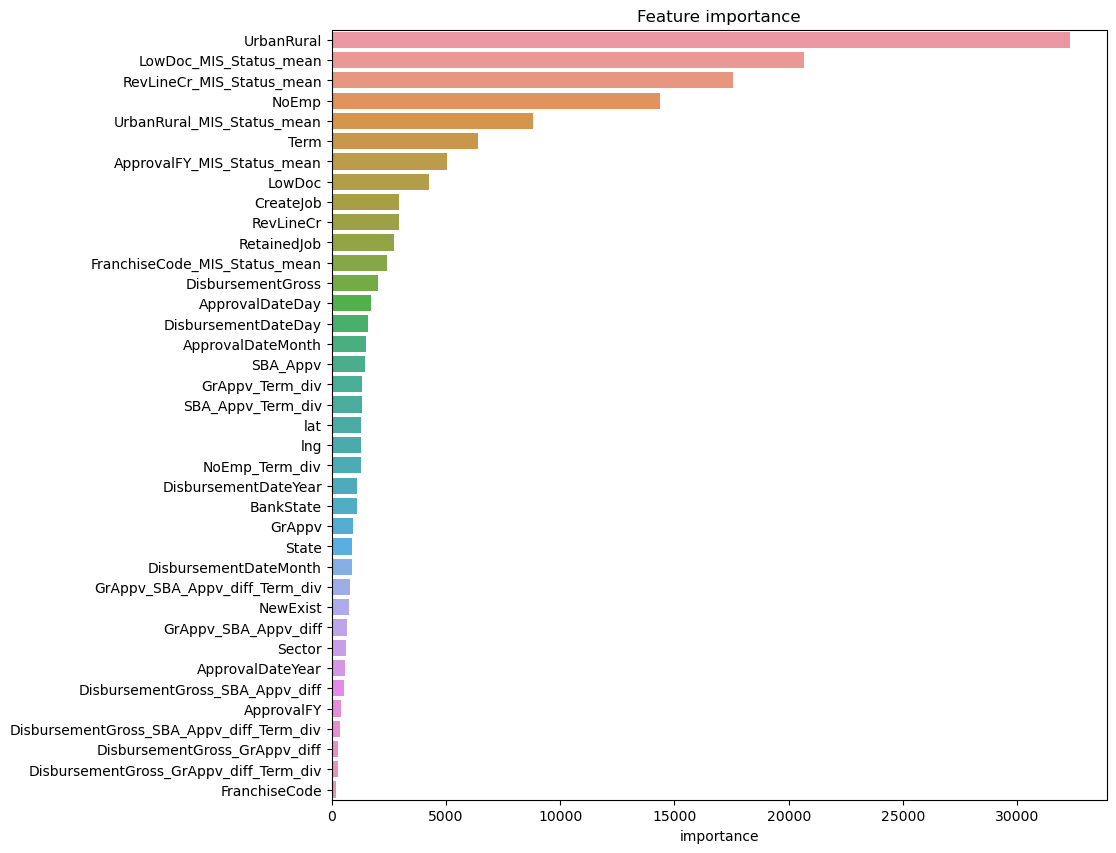

In [271]:
feature_importance_list = np.zeros(len(model.feature_importances_), dtype=np.float32)
for model_list_ in model_list:
    for model in model_list_:
        feature_importance_list += model.feature_importances_
    # 特徴量重要度を表示する
    importance = pd.DataFrame(model.feature_importances_, index=train_df.drop([target_col,"fold"]).columns, columns=['importance'])
    # グラフ化
    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y=importance.sort_values('importance', ascending=False).index, data=importance.sort_values('importance', ascending=False))
    plt.title('Feature importance')
    plt.show()

In [272]:
test_proba_list = []
for model_list_ in model_list:
    test_proba = np.zeros((len(test_df), 2), dtype=np.float32)
    for model in model_list_:
        test_proba += model.predict_proba(test_df.to_numpy())
    test_proba_list.append(test_proba)

test_proba = test_proba_list[0]
max_indices = np.argmax(test_proba, axis=1)

# index_listとmax_indices持つデータフレームを作成
_ = pd.read_csv(f'{DATA_PATH}/test.csv')
submission_df = pd.DataFrame({'id': _["Unnamed: 0"].to_list(), target_col: max_indices})

submission_df.to_csv(f'{OUTPUT_PATH}/{EXP_DIR}_{score}.csv', index=False, header=False )

In [273]:
submission_df[target_col].value_counts()

MIS_Status
1    38494
0     3814
Name: count, dtype: int64

In [30]:
train_df[target_col].value_counts()

MIS_Status,counts
i64,u32
0,4540
1,37767
